In [1]:
from rdkit.Chem.inchi import *
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
import urllib
import pandas as pd
import numpy as np
from load_data import SMRTDataset, SMRTDatasetRetained, MetabobaseDataset, RikenDataset, MassBank1Dataset
import torch
from torch.utils.data import random_split
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
# from pandarallel import pandarallel
# pandarallel.initialize(nb_workers=16)

torch.manual_seed(1234)
dataset = SMRTDatasetRetained('./SMRT_Retain')
train_len = int(dataset.__len__() * 0.9)
test_len = dataset.__len__() - train_len
train_dataset, test_dataset = random_split(dataset, [train_len, test_len])
train_len_2 = int(train_len * 0.9)
dev_len = train_len - train_len_2
train_dataset, dev_data_set = random_split(train_dataset, [train_len_2, dev_len])

In [2]:
test_data_frame = pd.DataFrame(index=range(10000000),columns=['inchi', 'formula','real_rt'])

In [3]:
for i in range(len(test_dataset)):
    data = test_dataset[i]
    test_data_frame.loc[i] = {'inchi':data.inchi,'formula':data.formula,'real_rt':data.y.cpu().item()}

In [6]:
import os
from tqdm import tqdm
import multiprocessing
from rdkit.Chem.inchi import *
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
import urllib
import pandas as pd
import numpy as np
from load_data import SMRTDataset, SMRTDatasetRetained, MetabobaseDataset, RikenDataset, MassBank1Dataset
import torch
from torch.utils.data import random_split
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
from functools import partial
# from pandarallel import pandarallel
# pandarallel.initialize(nb_workers=16)

torch.manual_seed(1234)

dataset = SMRTDatasetRetained('./SMRT_Retained')

train_len = int(dataset.__len__() * 0.9)
test_len = dataset.__len__() - train_len
train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

train_len_2 = int(train_len * 0.9)
dev_len = train_len - train_len_2
train_dataset, dev_data_set = random_split(train_dataset, [train_len_2, dev_len])

test_data_frame = pd.DataFrame(columns=['inchi', 'formula','real_rt'])
for i in range(len(test_dataset)):
    data = test_dataset[i]
    test_data_frame.loc[i] = {'inchi':data.inchi,'formula':data.formula,'real_rt':data.y.cpu().item()}
path = 'results_of_search_smrt_retained'
# frame = pd.DataFrame(columns=['inchi_true','rt_true','inchi','rt_pred'])
frame_list = multiprocessing.Manager().list([None for _ in range(len(test_data_frame))])
def transfer(index_file,frame_list_to_write):
    inchi_true = test_data_frame['inchi'][index_file]
    rt_true = test_data_frame['real_rt'][index_file]
    formula = test_data_frame['formula'][index_file]
    if os.path.exists(f'./{path}/{formula}_results.csv'):
        csv = pd.read_csv(f'./{path}/{formula}_results.csv')
        frame = pd.DataFrame(index=range(10000),columns=['inchi_true','rt_true','inchi','rt_pred'])
        for j in range(len(csv)):
            frame.loc[j] = {
                            'inchi_true':inchi_true,
                            'rt_true':rt_true,
                            'inchi':csv['inchi'][j],
                            'rt_pred':csv['pred_rt'][j]
                            }
            
        frame_list_to_write[index_file] = frame
        # print(f'{index_file}success')



partial_work = partial(transfer, frame_list_to_write=frame_list)
x = list(range(len(test_data_frame)))

with Pool(processes = 50) as pool:
    result = list(tqdm(pool.imap(partial_work, x), total=len(test_data_frame)))


100%|██████████| 8004/8004 [12:54<00:00, 10.34it/s] 


In [8]:
len(os.listdir('./search_smrt_retained/')),len(os.listdir('./search_smrt_all'))

(10628, 16940)

In [9]:
frame_list[0]

,inchi_true,rt_true,inchi,rt_pred
0,InChI=1S/C20H24N4O3S/c1-20(2)16-14-15(7-8-17(1...,633.299988,InChI=1S/C20H24N4O3S/c1-12-10-18(14(3)27-12)13...,720.730774
1,InChI=1S/C20H24N4O3S/c1-20(2)16-14-15(7-8-17(1...,633.299988,InChI=1S/C20H24N4O3S/c1-2-11-23-19(26)17-16(14...,815.408936
2,InChI=1S/C20H24N4O3S/c1-20(2)16-14-15(7-8-17(1...,633.299988,InChI=1S/C20H24N4O3S/c1-5-24(20-21-16-8-6-7-9-...,772.919983
3,InChI=1S/C20H24N4O3S/c1-20(2)16-14-15(7-8-17(1...,633.299988,InChI=1S/C20H24N4O3S/c1-15-14-24(12-11-23(15)1...,595.883667
4,InChI=1S/C20H24N4O3S/c1-20(2)16-14-15(7-8-17(1...,633.299988,InChI=1S/C20H24N4O3S/c1-4-10-21-19(25)14(2)28-...,720.426636
...,...,...,...,...
9995,NaN,NaN,NaN,NaN
9996,NaN,NaN,NaN,NaN
9997,NaN,NaN,NaN,NaN
9998,NaN,NaN,NaN,NaN


In [10]:
frame = pd.concat(frame_list)
frame = frame.dropna()

In [13]:
frame[-1]

KeyError: -1

In [14]:


frame.to_csv('./results/all_predictions_of_search_by_all.csv')

In [6]:
count = 0
for i in frame_list:
    if i is not None:
        count = count+1
count

8001

In [ ]:
frame = pd.concat(frame_list)
len(frame)

In [ ]:
frame = frame.dropna()
len(frame)

In [15]:
frame['pos'] = frame['inchi']==frame['inchi_true']
frame['re'] = 100*abs(frame['rt_true']-frame['rt_pred'])/frame['rt_true']

In [18]:
import pandas as pd
import numpy as np
from load_data import SMRTDataset, SMRTDatasetRetained, MetabobaseDataset, RikenDataset, MassBank1Dataset
import torch
from torch.utils.data import random_split
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

frame['re'] = 100*abs(frame['rt_true']-frame['rt_pred'])/frame['rt_true']

def ROC(df, threshold):
    # TPR=[]
    # FPR=[]
    TPR=[0]*len(threshold)
    FPR=[0]*len(threshold)

    df['pos'] = df['inchi']==df['inchi_true']
    P = len(df[df.pos==True])
    N = len(df[df.pos==False])
    # print(P, N)
    for index, thresh in enumerate(tqdm(threshold)):
        df['pos_thresh'] = df['re']<thresh
        TP = len(df[(df['pos']==True)&(df['pos_thresh']==True)])
        FP = len(df[(df['pos']==False)&(df['pos_thresh']==True)])
        TPR[index] = TP/P
        FPR[index] = FP/N
        # TPR.append(TP/P)
        # FPR.append(FP/N)
    print ('Best threshold:', threshold[np.argmax(np.array(TPR)-np.array(FPR))])
    return (TPR, FPR, threshold[np.argmax(np.array(TPR)-np.array(FPR))])
def ROC_AUC(TPR, FPR):
    ROC_AUC=0
    for i in tqdm(range(len(FPR)-1)):
        ROC_AUC+= (FPR[i+1]-FPR[i])*(TPR[i+1]+TPR[i])/2
    return ROC_AUC

def get_search_space_reduction(df, threshold):
    df['filtered'] = df['re']>threshold
    total, filtered=[0]*len(df[df['pos']==True].inchi),[0]*len(df[df['pos']==True].inchi)
    for index, inchi in enumerate(tqdm(df[df['pos']==True].inchi)):
        new_df = df[df['inchi_true']==inchi]
        total[index] = len(new_df)
        filtered[index] = len(new_df[new_df['filtered'] ==True])
        # total.append(len(new_df))
        # filtered.append(len(new_df[new_df['filtered'] ==True]))
    return total, filtered

threshold=np.arange(0, 200, 0.01)
TPR, FPR, thresh = ROC(frame, threshold)
AUC = ROC_AUC(TPR, FPR)
total, filtered = get_search_space_reduction(frame,thresh)






KeyboardInterrupt: 

In [ ]:
x=[0,1]
y=[0,1]
labels=['Total', 'Filtered']
fig, axs = plt.subplots(1,2, figsize=(6, 3.2), sharey=False, dpi=1200)
i=0
matplotlib.rcParams.update({'font.size': 8})
# for ds in [ds_name]:
    #print(st.mean(RF[ds]))
axs[0].plot(FPR, TPR)
axs[0].plot(x,y)
axs[0].set_yticks([0,0.5, 1])
axs[0].set_xticks([0,0.5, 1])
axs[0].set_xlabel('FPR')
axs[0].set_ylabel('TPR')
axs[0].set_yticklabels(['0', '0.5', '1'])
axs[0].set_xticklabels(['0', '0.5', '1'])


axs[1].boxplot((total, filtered), showfliers=False)
axs[1].set_xticklabels(labels, fontsize=8)
axs[1].set_ylabel('No candidates')
fig.tight_layout(pad=3.0)

In [2]:
import pandas as pd
frame = pd.read_csv('./ all_predictions_of_search_by_all.csv')

In [3]:
frame['re'] = 100*abs(frame['rt_true']-frame['rt_pred'])/frame['rt_true']

In [6]:
import numpy as np
from tqdm import tqdm

def ROC(df, threshold):
    TPR = [None for _ in range(len(threshold))]
    FPR = [None for _ in range(len(threshold))]

    df['pos'] = df['inchi']==df['inchi_true']
    P = len(df[df.pos==True])

    N = len(df[df.pos==False])
    print(P, N)
    for i,thresh in enumerate(tqdm(threshold)):
        df['pos_thresh'] = df['re']<thresh
        TP = len(df[(df['pos']==True)&(df['pos_thresh']==True)])
        FP = len(df[(df['pos']==False)&(df['pos_thresh']==True)])
        TPR[i] = (TP/P)
        FPR[i] = (FP/N)
        # TPR.append(TP/P)
        # FPR.append(FP/N)
    print ('Best threshold:', threshold[np.argmax(np.array(TPR)-np.array(FPR))])
    # with open('../results/ROC_curves.txt', 'a') as f:
    #     f.write('Best threshold:'+ str(threshold[np.argmax(np.array(TPR)-np.array(FPR))])+'\n')
    return (TPR, FPR, threshold[np.argmax(np.array(TPR)-np.array(FPR))])
def ROC_AUC(TPR, FPR):
    ROC_AUC=0
    for i in range(len(FPR)-1):
        ROC_AUC+= (FPR[i+1]-FPR[i])*(TPR[i+1]+TPR[i])/2
    return ROC_AUC

In [7]:
threshold=np.arange(0, 200, 0.1)
TPR, FPR, thresh = ROC(frame, threshold)
len(TPR)

7533 31385562


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:48:44<00:00,  3.26s/it]

Best threshold: 5.7


2000

In [8]:
AUC  = ROC_AUC(TPR, FPR)
print('AUC = ', AUC)
print(thresh)

AUC =  0.8553381831680041
5.7


In [10]:
from tqdm import tqdm
import multiprocessing
from multiprocessing import Pool
from functools import partial


# inchi_list = multiprocessing.Manager().list(frame[frame['pos']==True].inchi)
# total = multiprocessing.Manager().list([None for _ in range(len(inchi_list))])
# filtered = multiprocessing.Manager().list([None for _ in range(len(inchi_list))])
# def search_space_reduction(inchi_index,frame_to_read):
#     new_df = frame_to_read[frame_to_read['inchi_true']==inchi_list[inchi_index]]
#     total[inchi_index] = len(new_df)
#     filtered[inchi_index] = len(new_df[new_df['filtered'] ==True])
#
# partial_work = partial(search_space_reduction, frame_to_read=frame)
# x = list(range(len(inchi_list)))
# with Pool(processes = 16) as pool:
#     result = list(tqdm(pool.imap(partial_work, x), total=len(inchi_list)))

def get_search_space_reduction(df, threshold):
    df['filtered'] = df['re']>threshold
    total, filtered=[],[]
    for inchi in tqdm(df[df['pos']==True].inchi):
        new_df = df[df['inchi_true']==inchi]
        total.append(len(new_df))
        filtered.append(len(new_df[new_df['filtered'] ==True]))
    return total, filtered

total, filtered = get_search_space_reduction(frame,thresh)
total, filtered

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7533/7533 [1:50:45<00:00,  1.13it/s]


([2,
  2330,
  3317,
  4259,
  2404,
  1176,
  516,
  16892,
  11577,
  4848,
  937,
  3178,
  230,
  390,
  57,
  1853,
  26,
  2111,
  1421,
  6764,
  14965,
  8334,
  4475,
  6080,
  12484,
  193,
  14580,
  198,
  3,
  11832,
  14787,
  2849,
  7566,
  1228,
  536,
  499,
  1316,
  2476,
  3871,
  2730,
  4187,
  4221,
  157,
  104,
  11195,
  10544,
  3215,
  3698,
  28557,
  343,
  10709,
  3485,
  9430,
  3412,
  9327,
  4452,
  3721,
  121,
  575,
  9766,
  12508,
  4413,
  883,
  9481,
  827,
  14609,
  315,
  10181,
  2113,
  42,
  5122,
  4620,
  460,
  7506,
  5688,
  9020,
  2528,
  896,
  1427,
  7855,
  422,
  2086,
  4575,
  1694,
  473,
  3087,
  84,
  925,
  27369,
  3172,
  7539,
  1583,
  4484,
  773,
  5532,
  15884,
  4331,
  823,
  14280,
  1502,
  2848,
  11,
  279,
  3139,
  398,
  1096,
  648,
  655,
  6508,
  9,
  2330,
  1882,
  507,
  4377,
  26120,
  353,
  11426,
  11273,
  383,
  1202,
  21,
  7571,
  5363,
  277,
  1117,
  1535,
  175,
  4475,
  1807,
 

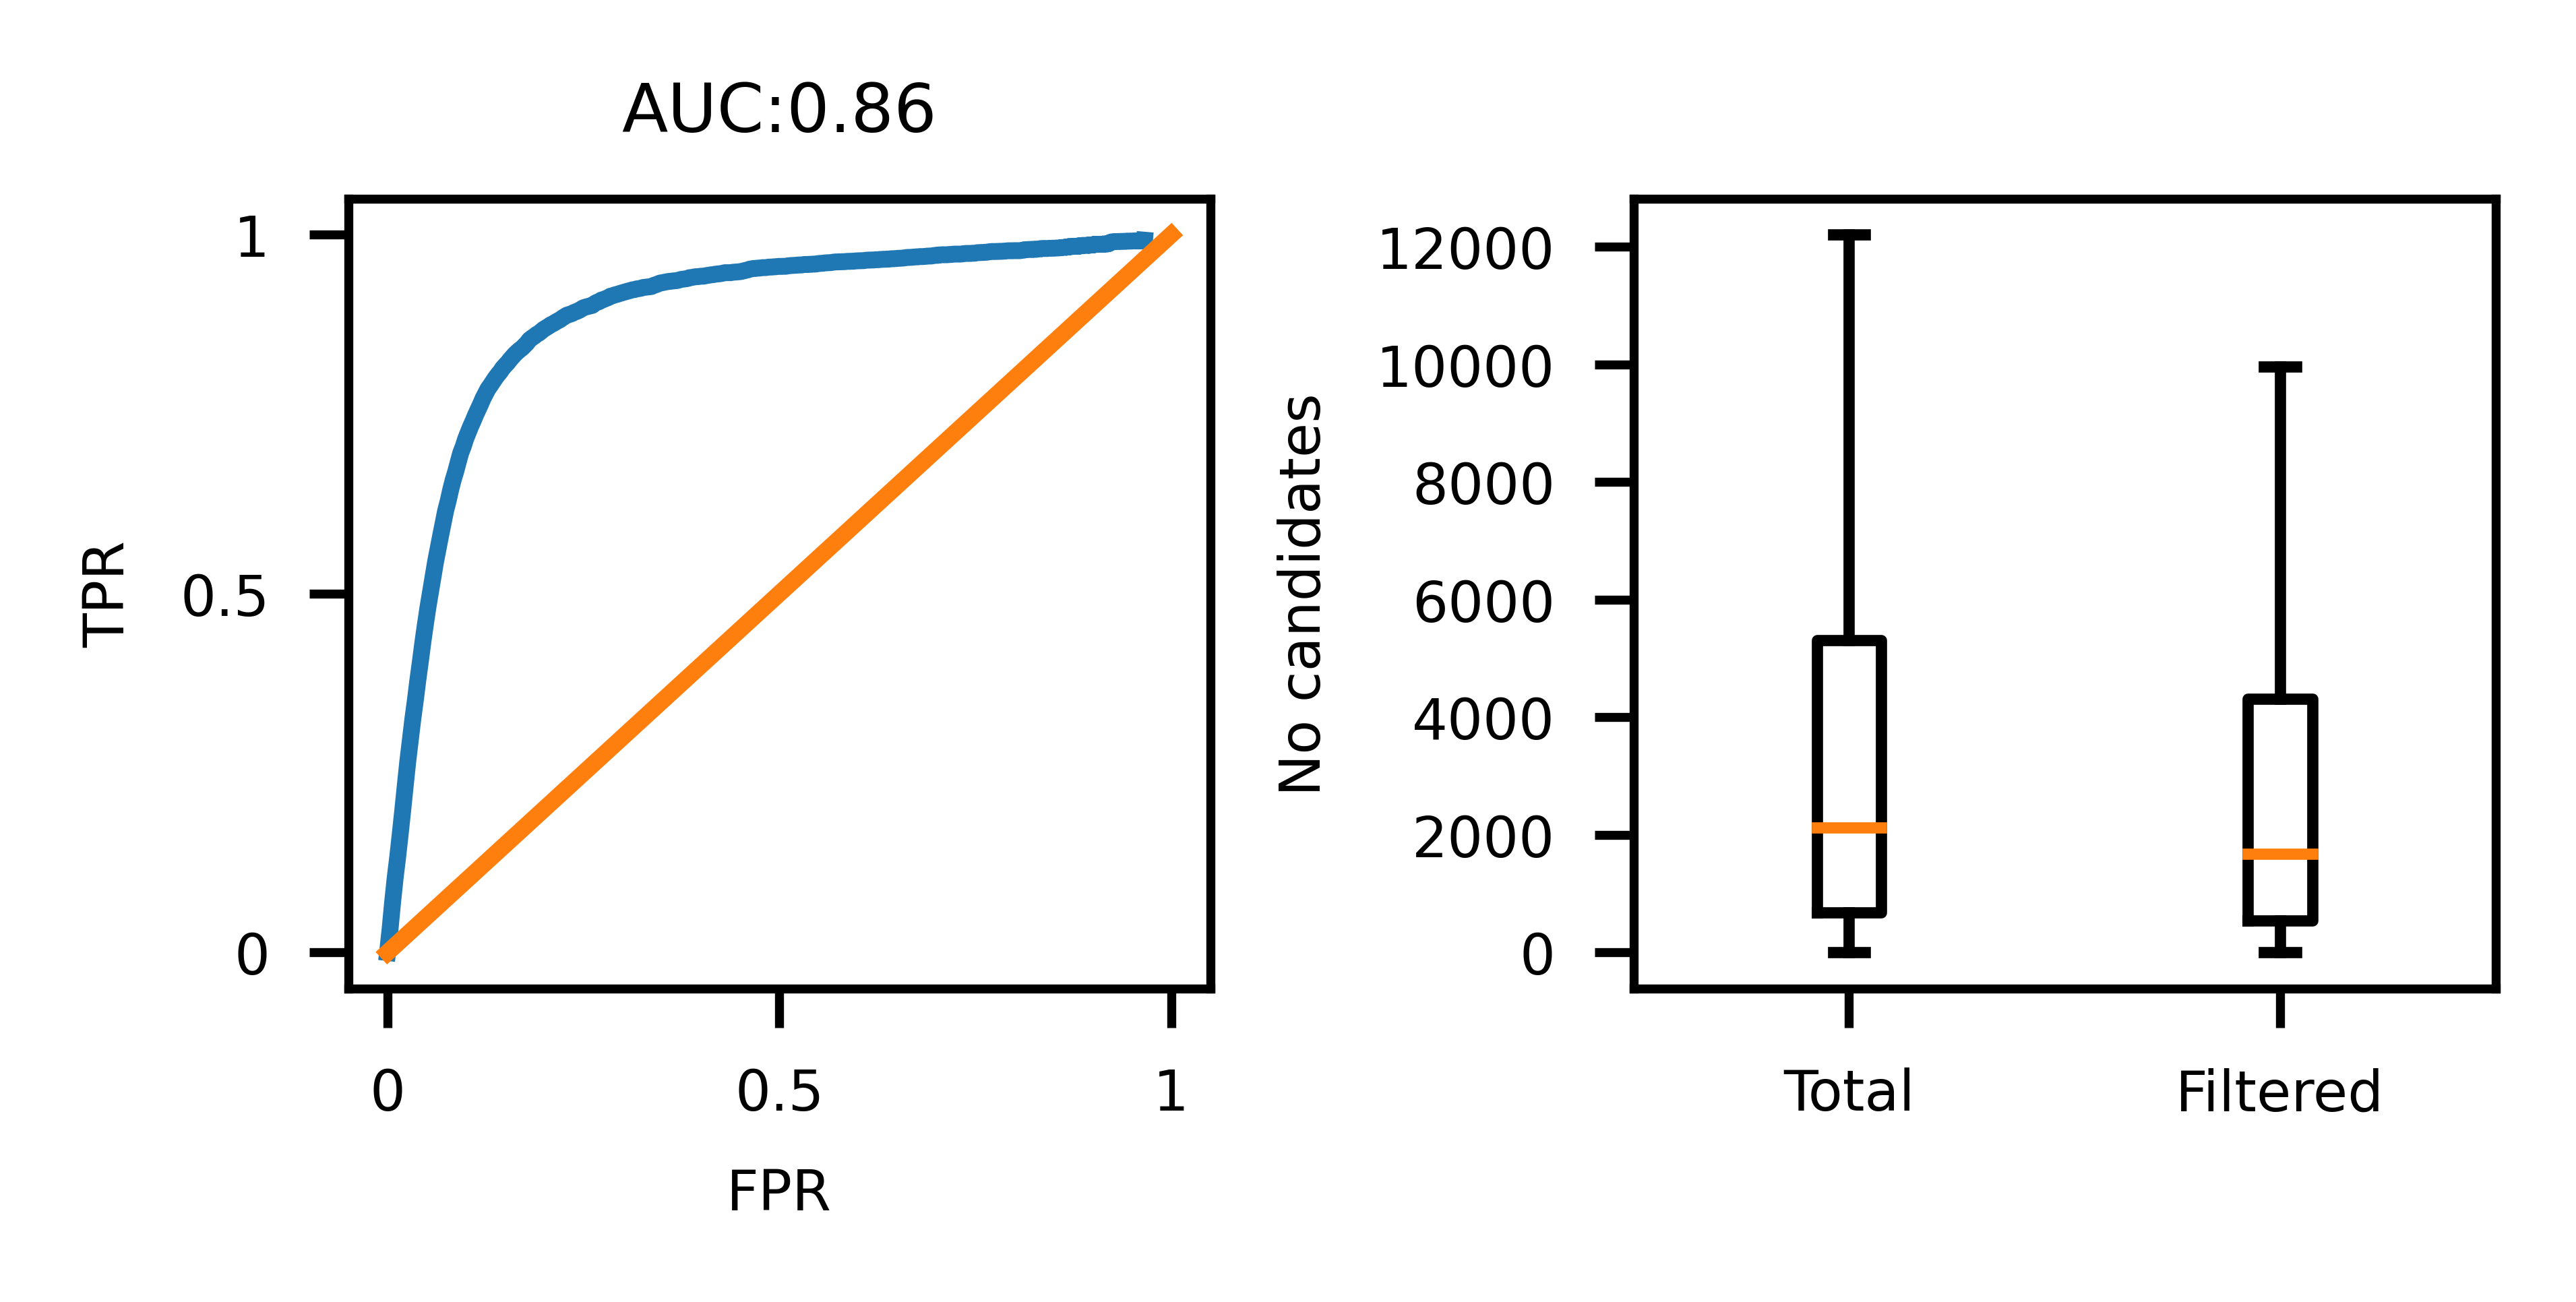

In [11]:
import matplotlib
import matplotlib.pyplot as plt
x = [0,1]
y = [0,1]
labels=['Total', 'Filtered']
fig, axs = plt.subplots(1,2, figsize=(8/2.54, 4/2.54), sharey=False, dpi=1200)
i=0
matplotlib.rcParams.update({'font.size': 5})
# for ds in [ds_name]:
    #print(st.mean(RF[ds]))
axs[0].plot(FPR, TPR)
axs[0].plot(x,y)
axs[0].set_yticks([0,0.5, 1])
axs[0].set_xticks([0,0.5, 1])
axs[0].set_xlabel('FPR')
axs[0].set_ylabel('TPR')
axs[0].set_yticklabels(['0', '0.5', '1'])
axs[0].set_xticklabels(['0', '0.5', '1'])
axs[0].set_title(f'AUC:{AUC:.2f}')

axs[1].boxplot((total, filtered), showfliers=False)
axs[1].set_xticklabels(labels, fontsize=5)
axs[1].set_ylabel('No candidates')
fig.tight_layout(pad=3.0/2.54)
plt.savefig('./data/ROC_all.svg')

In [12]:
filter_rate = np.array(filtered)/np.array(total) *100

<AxesSubplot: >

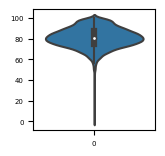

In [13]:
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(4/2.54, 4/2.54))
sns.violinplot(filter_rate)

In [14]:
filter_rate.mean()

80.89572835809633

In [15]:
len(TPR)

2000

In [289]:
read_csv = pd.read_csv("./search_smrt/C15H13BrN2O4S2.csv",sep=':',index_col=None,header=None)
read_csv

,0
0,InChI=1S/C15H13BrN2O4S2/c1-9-13(16)14(22-17-9)...
1,InChI=1S/C15H13BrN2O4S2/c1-9-13(16)14(22-17-9)...
2,InChI=1S/C15H13BrN2O4S2/c1-9-13(16)14(22-17-9)...
3,InChI=1S/C15H13BrN2O4S2/c1-15(6-23-14-17-7-4-2...
4,InChI=1S/C15H13BrN2O4S2/c16-12-3-1-11(2-4-12)1...
...,...
68,InChI=1S/C15H13BrN2O4S2/c16-12-6-4-11(5-7-12)1...
69,InChI=1S/C15H13BrN2O4S2/c16-12-6-4-11(5-7-12)1...
70,InChI=1S/C15H13BrN2O4S2/c1-18-12-5-3-9(7-14(12...
71,InChI=1S/C15H13BrN2O4S2/c1-18-11-5-4-10(8-13(1...


In [293]:
read_csv[0]

0     InChI=1S/C15H13BrN2O4S2/c1-9-13(16)14(22-17-9)...
1     InChI=1S/C15H13BrN2O4S2/c1-9-13(16)14(22-17-9)...
2     InChI=1S/C15H13BrN2O4S2/c1-9-13(16)14(22-17-9)...
3     InChI=1S/C15H13BrN2O4S2/c1-15(6-23-14-17-7-4-2...
4     InChI=1S/C15H13BrN2O4S2/c16-12-3-1-11(2-4-12)1...
                            ...                        
68    InChI=1S/C15H13BrN2O4S2/c16-12-6-4-11(5-7-12)1...
69    InChI=1S/C15H13BrN2O4S2/c16-12-6-4-11(5-7-12)1...
70    InChI=1S/C15H13BrN2O4S2/c1-18-12-5-3-9(7-14(12...
71    InChI=1S/C15H13BrN2O4S2/c1-18-11-5-4-10(8-13(1...
72    InChI=1S/C15H13BrN2O4S2/c1-17(8-9-3-6-13(16)23...
Name: 0, Length: 73, dtype: object